## Por qué usar la api de tf.data?

Permite aprovechar paralelización en el momento de cargar los datos, aprovechando la GPU y cargando los datos a la vez que se entrena el modelo, para poder evitar perder tiempo. Este paralelismo permite leer datos de múltiples archivos a la vez utilizando tecnicas de batching, shuffling. Mientras la GPU está entrenando el modelo aprovecha la CPU para cargar y pre procesar el próximo lote de datos.

También permite procesar datasets que no entran en la RAM, y aprovecha al máximo todos los recursos. Puede leer csvs, binary files con largos establecidos de registros y binary files que usan Tensor Flow TFR Record format que soporta registros de varios tamaños.

TF.Data api también soporta leer datos desde SQL. También brinda las capas de pre procesamiento de datos que se pueden incluir en el modelo para evitar diferencias entre desarrollo y producción.

Ingesting a large dataset and preprocessing it efficiently can be a complex engineering challenge. The Data API makes it fairly simple. It offers many features, including loading data from various sources (such as text or binary files), reading data in parallel from multiple sources, transforming it, interleaving the records, shuffling the data, batching it, and prefetching it.

## Cuales son los beneficios de dividir un dataset pesado en múltiples archivos?

El descenso de gradiente funciona mejor cuando las instancias son independientes e identicamente distribuidas. Una forma de hacerlo es con el método shuffle, que va llenando un buffer (que es un dataset nuevo) con instancias del dataset inicial, cada vez que se necesite una instancia se saca una del dataset inicial hasta que se haya recorrido todo el dataset. El buffer debe tener el tamaño adecuado sino es lo mismo que no hacerlo.

El beneficio de tener múltiples archivos es evitar el orden intrinseco de los datos en el archivo inicial, para ello se divide en varios archivos, se hace shuffle, y luego se intercala el orden de archivos para obtener instancias. Esto permite manejar datasets gigantes que no entran en una máquina sola, es más fácil dividir los datos en múltiples subsets que manipular un dataset gigante.

Splitting a large dataset into multiple files makes it possible to shuffle it at a coarse level before shuffling it at a finer level using a shuffling buffer. It also makes it possible to handle huge datasets that do not fit on a single machine. It's also simpler to manipulate thousands of small files rather than one huge file; for example, it's easier to split the data into multiple subsets. Lastly, if the data is split across multiple files spread across multiple servers, it is possible to download several files from different servers simultaneously, which improves the bandwidth usage.

## Durante el entrenamiento, como se puede identificar que el input pipeline está causando demoras?
Se puede usar TensorBoard para checkear si la GPU está siendo utilizada al máximo, de lo contrario existe holgura entre el tiempo de procesamiento de los datos que impide el entrenamiento continúo, hay que asegurarse de que se lea y preprocese los datos en paralelo y múltiples hilos. Si esto es insuficiente, puede ser que el pre procesamiento no sea eficiente, sino se puede probar guardandooslo el dataset en múltiples TFRecord files, y pre procesando con antelación así no se tiene que hacer durante el entrenamiento. Si todo esto no es necesario hay que aumentar la capacidad de computo. 

You can use TensorBoard to visualize profiling data: if the GPU is not fully utilized then your input pipeline is likely to be the bottleneck. You can fix it by making sure it reads and preprocesses the data in multiple threads in parallel, and ensuring it prefetches a few batches. If this is insufficient to get your GPU to 100% usage during training, make sure your preprocessing code is optimized. You can also try saving the dataset into multiple TFRecord files, and if necessary perform some of the preprocessing ahead of time so that it does not need to be done on the fly during training (TF Transform can help with this). If necessary, use a machine with more CPU and RAM, and ensure that the GPU bandwidth is large enough.

## Se puede guardar cualquier tipo de dato en un archivo TFRecord o solo buffers de protocolo serializados?
Si, cualquier tipo binario de dato se puede guardar en un TFRecord, son una secuencia de archivos binarios arbitrarios. En la practica la mayoria contiene potobufs porque esto aprovecha las ventajas de acceso multiplataforma, lenguaje y actualización de definición. 

A TFRecord file is composed of a sequence of arbitrary binary records: you can store absolutely any binary data you want in each record. However, in practice most TFRecord files contain sequences of serialized protocol buffers. This makes it possible to benefit from the advantages of protocol buffers, such as the fact that they can be read easily across multiple platforms and languages and their definition can be updated later in a backward-compatible way.

## Why would you go through the hassle of converting all your data to the Example protobuf format? Why not use your own protobuf definition?
El formato ejemplo de protobuf tiene mucha compatibilídad por parte de TensorFlow que ya incluye muchas operaciones para usarlo en `tf.io.parse`*`example()`. El formato es lo suficientemente flexible para representar la mayoría de los datasets, y además permite tener compatibilídad facilmente con otros lenguajes.

En caso de usar mi propia definición de protobuf, hay que compilar usando protoc y `--descriptor_set_out` and `--include_imports` para exportar la descripción del tipo y usar `tf.io.decode_proto()` para parsear la definición del protobuf, esto requiere luego deployear la definición con el modelo.

The `Example` protobuf format has the advantage that TensorFlow provides some operations to parse it (the `tf.io.parse`*`example()` functions) without you having to define your own format. It is sufficiently flexible to represent instances in most datasets. However, if it does not cover your use case, you can define your own protocol buffer, compile it using `protoc` (setting the `--descriptor_set_out` and `--include_imports` arguments to export the protobuf descriptor), and use the `tf.io.decode_proto()` function to parse the serialized protobufs (see the "Custom protobuf" section of the notebook for an example). It's more complicated, and it requires deploying the descriptor along with the model, but it can be done.

## When using TFRecords, when would you want to activate compression? Why not do it systematically?
Se activa compresión cuando el script de entrenamiento requiere descargar el dataset, entonces es viable reducir el tiempo de descarga. Si solo se va a utilizar localmente no es viable porque añade tiempo de descompresión. 

When using TFRecords, you will generally want to activate compression if the TFRecord files will need to be downloaded by the training script, as compression will make files smaller and thus reduce download time. But if the files are located on the same machine as the training script, it's usually preferable to leave compression off, to avoid wasting CPU for decompression.



## Data can be preprocessed directly when writing the data files, or within the tf.data pipeline, or in preprocessing layers within your model. Can you list a few pros and cons of each option?

# 🧠 Where to Preprocess Your Data in TensorFlow

Data can be preprocessed at **three different stages** in a TensorFlow workflow:  
1. When writing files (offline, before training)  
2. Inside the `tf.data` input pipeline (on the fly)  
3. Inside preprocessing layers in the model  

Each approach has clear pros and cons.

---

## 🏗️ 1. Preprocessing When Writing Data Files (Offline)

### ✅ Pros
- **Fastest training input:** data is already transformed — minimal pipeline overhead.  
- **Deterministic & repeatable:** once written, always the same.  
- **Framework-agnostic:** the data can be consumed by TensorFlow, PyTorch, or others.  
- **Efficient for heavy transforms:** feature engineering, joins, or global aggregations.

### ❌ Cons
- **Inflexible:** any change in preprocessing requires rewriting the dataset.  
- **Storage cost:** may need to keep both raw and processed copies.  
- **Potential data leakage:** if statistics were computed using train+test data.  
- **Versioning overhead:** must track preprocessing + dataset versions manually.

### 💡 Best for
- Huge, stable datasets.  
- Heavy preprocessing that rarely changes.  
- Production pipelines (TFX, Beam, Spark) that materialize features once.

---

## ⚙️ 2. Preprocessing in `tf.data` Pipeline (On-the-Fly)

### ✅ Pros
- **Flexible:** change transforms without rewriting data.  
- **Efficient:** runs in parallel, can be cached and prefetched.  
- **Keeps raw source intact:** easier to reproduce experiments.  
- **Perfect for augmentation:** random transformations per epoch (flips, crops, etc.).

### ❌ Cons
- **Training-only by default:** must reimplement preprocessing for inference.  
- **Possible bottleneck:** if heavy transforms aren’t parallelized.  
- **Harder debugging:** graph mode errors, silent performance issues.

### 💡 Best for
- Rapid experimentation.  
- Data augmentation that changes every epoch.  
- When you control separate inference preprocessing elsewhere.

---

## 🧩 3. Preprocessing in Model Layers (Within the Graph)

### ✅ Pros
- **Training–serving parity:** preprocessing saved *inside* the model.  
- **Portable:** works on TensorFlow Serving, TF Lite, and other deployments.  
- **Runs on accelerators:** can execute on GPU/TPU if lightweight.  
- **Self-contained:** statistics (mean, std) stored in model weights.

### ❌ Cons
- **Heavier preprocessing slows training:** better to move expensive steps outside.  
- **Limited expressiveness:** not ideal for complex joins or dataset-level operations.  
- **Requires model re-export:** every time preprocessing logic changes.

### 💡 Best for
- Lightweight per-example transforms (normalization, tokenization).  
- Serving in multiple environments without separate pipelines.  
- Ensuring consistent preprocessing between training and inference.

---

## ⚖️ Quick Decision Guide

| Type of Transform | Recommended Location |
|--------------------|----------------------|
| Heavy global feature engineering | Write-time |
| Random augmentation (flip, crop, noise) | `tf.data` pipeline |
| Per-example normalization / tokenization | Model preprocessing layer |
| You need one deployable model artifact | Model preprocessing layer |
| Rapid iteration during training | `tf.data` pipeline |

---

## 🚀 Real-World Hybrid Strategy

Most production pipelines mix all three:

1. **Offline:** heavy, global transforms (joins, aggregations, stable feature engineering).  
2. **`tf.data`:** lightweight, stochastic, or per-epoch augmentations.  
3. **Model layers:** final normalization/tokenization to guarantee parity at serving time.

This approach balances **speed, flexibility, and reliability** across both training and deployment.


# 🧠 Dónde Preprocesar Tus Datos en TensorFlow

Los datos pueden preprocesarse en **tres etapas diferentes** dentro de un flujo de trabajo con TensorFlow:  
1. Al escribir los archivos (offline, antes del entrenamiento)  
2. Dentro del pipeline de entrada `tf.data` (en tiempo real)  
3. Dentro de las capas de preprocesamiento del modelo  

Cada enfoque tiene ventajas y desventajas claras.

---

## 🏗️ 1. Preprocesamiento al Escribir los Archivos (Offline)

### ✅ Ventajas
- **Entrenamiento más rápido:** los datos ya están transformados, mínimo costo en el pipeline.  
- **Determinista y reproducible:** una vez escrito, siempre se comporta igual.  
- **Agnóstico al framework:** los datos pueden ser consumidos por TensorFlow, PyTorch, etc.  
- **Eficiente para transformaciones pesadas:** ingeniería de features, joins o agregaciones globales.

### ❌ Desventajas
- **Poco flexible:** cualquier cambio requiere reescribir el dataset.  
- **Mayor consumo de almacenamiento:** puede ser necesario guardar la versión cruda y la procesada.  
- **Riesgo de fuga de información:** si las estadísticas se calcularon con datos de entrenamiento + prueba.  
- **Gestión de versiones:** hay que versionar dataset y transformaciones manualmente.

### 💡 Ideal cuando
- Los datasets son grandes y estables.  
- Las transformaciones son costosas pero poco cambiantes.  
- Tenés un pipeline de producción (TFX, Beam, Spark) que materializa las features una sola vez.

---

## ⚙️ 2. Preprocesamiento en el Pipeline `tf.data` (En Tiempo Real)

### ✅ Ventajas
- **Flexible:** podés cambiar transformaciones sin reescribir los datos.  
- **Eficiente:** soporta paralelización, cache y prefetch.  
- **Conserva la fuente cruda:** facilita reproducir experimentos.  
- **Ideal para aumentación:** transformaciones aleatorias por época (rotar, cortar, etc.).

### ❌ Desventajas
- **Solo para entrenamiento:** se debe reimplementar el preprocesamiento para inferencia.  
- **Puede ser un cuello de botella:** si no se paraleliza correctamente.  
- **Más difícil de depurar:** errores en modo gráfico o bajo rendimiento silencioso.

### 💡 Ideal cuando
- Estás iterando rápido en los features.  
- Usás aumentación aleatoria de datos.  
- Podés mantener una lógica de preprocesamiento separada para inferencia.

---

## 🧩 3. Preprocesamiento en Capas del Modelo (Dentro del Grafo)

### ✅ Ventajas
- **Paridad entrenamiento–serving:** el preprocesamiento se guarda dentro del modelo.  
- **Portabilidad:** funciona en TensorFlow Serving, TF Lite, etc.  
- **Acelerado:** puede ejecutarse en GPU/TPU si las operaciones son livianas.  
- **Autocontenido:** las estadísticas (media, desvío) se guardan como pesos del modelo.

### ❌ Desventajas
- **Puede ralentizar el entrenamiento:** si se incluyen transformaciones pesadas.  
- **Limitaciones expresivas:** no es ideal para joins complejos o operaciones a nivel dataset.  
- **Requiere reexportar el modelo:** cada vez que cambia la lógica de preprocesamiento.

### 💡 Ideal cuando
- Las transformaciones son ligeras y por ejemplo (normalización, tokenización).  
- Necesitás un modelo autocontenido que funcione igual en producción.  
- Querés evitar mantener pipelines de preprocesamiento externos.

---

## ⚖️ Guía Rápida de Decisión

| Tipo de Transformación | Lugar Recomendado |
|-------------------------|------------------|
| Ingeniería de features pesada y global | Escribir (offline) |
| Aumentación aleatoria (flip, crop, ruido) | Pipeline `tf.data` |
| Normalización / tokenización por ejemplo | Capa de preprocesamiento del modelo |
| Necesitás un único artefacto desplegable | Capa de preprocesamiento del modelo |
| Iteraciones rápidas en entrenamiento | Pipeline `tf.data` |

---

## 🚀 Estrategia Híbrida (la más usada en producción)

La mayoría de los pipelines combinan los tres niveles:

1. **Offline:** transformaciones globales o costosas (joins, agregaciones, features estables).  
2. **`tf.data`:** transformaciones ligeras o aleatorias por época.  
3. **Capas del modelo:** normalización o tokenización final para asegurar paridad entre entrenamiento y serving.

Este enfoque logra el equilibrio ideal entre **velocidad, flexibilidad y confiabilidad** tanto en entrenamiento como en despliegue.


## Name a few common ways you can encode categorical integer features. What about text?

Let's look at how to encode categorical text features and text:
    * To encode a categorical feature that has a natural order, such as a movie rating (e.g., "bad," "average," "good"), the simplest option is to use ordinal encoding: sort the categories in their natural order and map each category to its rank (e.g., "bad" maps to 0, "average" maps to 1, and "good" maps to 2). However, most categorical features don't have such a natural order. For example, there's no natural order for professions or countries. In this case, you can use one-hot encoding, or embeddings if there are many categories. With Keras, the `StringLookup` layer can be used for ordinal encoding (using the default `output_mode="int"`), or one-hot encoding (using `output_mode="one_hot"`). It can also perform multi-hot encoding (using `output_mode="multi_hot"`) if you want to encode multiple categorical text features together, assuming they share the same categories and it doesn't matter which feature contributed which category. For trainable embeddings, you must first use the `StringLookup` layer to produce an ordinal encoding, then use the `Embedding` layer.
    * For text, the `TextVectorization` layer is easy to use and it can work well for simple tasks, or you can use TF Text for more advanced features. However, you'll often want to use pretrained language models, which you can obtain using tools like TF Hub or Hugging Face's Transformers library. These last two options are discussed in Chapter 16.

# 🧩 Guía de Codificación de Datos Categóricos y Texto en TensorFlow

Cuando trabajás con Machine Learning, los modelos solo entienden **números**, así que necesitamos convertir las categorías o el texto en representaciones numéricas.  
A continuación se detallan los métodos más comunes para **features categóricas** y **texto**, junto con sus ventajas y cuándo usarlos.

---

## 🔢 Codificación de Features Categóricas (Enteros)

Supongamos que tenés una columna con categorías representadas por números enteros como `[0, 1, 2, 3]` (por ejemplo, tipo de producto o país).

---

### 1️⃣ One-Hot Encoding

Cada categoría se representa como un vector binario donde solo una posición es 1.

| Valor | Vector codificado |
|--------|-------------------|
| 0 | [1, 0, 0, 0] |
| 1 | [0, 1, 0, 0] |
| 2 | [0, 0, 1, 0] |
| 3 | [0, 0, 0, 1] |

**Ventajas**
- ✅ Simple y efectivo para pocas categorías.  
- ✅ Fácil de interpretar.

**Desventajas**
- ❌ Poco eficiente si hay muchas categorías (vectores muy grandes).  

**En TensorFlow**
```python
tf.keras.layers.CategoryEncoding(num_tokens=4, output_mode="one_hot")
````

---

### 2️⃣ Embeddings

Cada categoría entera se representa mediante un vector denso de dimensión fija, aprendido durante el entrenamiento.

| Categoría | Embedding (ejemplo) |
| --------- | ------------------- |
| 0         | [0.2, -0.5, 0.8]    |
| 1         | [0.7, 0.1, -0.3]    |

**Ventajas**

* ✅ Escalable para miles de categorías.
* ✅ Captura similitud entre categorías.

**Desventajas**

* ❌ Requiere entrenamiento para aprender las representaciones.

**En TensorFlow**

```python
tf.keras.layers.Embedding(input_dim=num_categorias, output_dim=embedding_dim)
```

---

### 3️⃣ Codificación Ordinal (Directa)

Se utilizan los enteros tal cual (`0, 1, 2, ...`) como valores numéricos.

**Ventajas**

* ✅ Muy simple.
* ✅ Sin memoria adicional.

**Desventajas**

* ❌ Solo tiene sentido si el orden es semántico.
* ❌ El modelo puede interpretar distancias inexistentes entre categorías.

---

## 📝 Codificación de Texto

El texto se compone de secuencias de palabras o caracteres.
Por lo tanto, requiere pasos adicionales de tokenización y representación.

---

### 1️⃣ Tokenización

Convierte las palabras o subpalabras en índices enteros.

**Ejemplo**

```
"El perro duerme" → [1, 42, 305]
```

**En TensorFlow**

```python
tf.keras.layers.TextVectorization(max_tokens=10000)
```

---

### 2️⃣ One-Hot o Multi-Hot (para texto corto)

Se representa la **presencia o ausencia** de palabras en un vocabulario como vectores binarios.

| Palabra | Vector            |
| ------- | ----------------- |
| “perro” | [0, 1, 0, 0, ...] |
| “gato”  | [0, 0, 1, 0, ...] |

**Ventajas**

* ✅ Simple e interpretable.

**Desventajas**

* ❌ No conserva el orden de las palabras ni el contexto.

---

### 3️⃣ Embeddings de Palabras

Cada palabra o token se representa con un vector denso (preentrenado o aprendido).

**Ejemplo**

```
"perro" → [0.11, -0.34, 0.87, ...]
```

**Ventajas**

* ✅ Captura similitud semántica (“perro” ≈ “gato”).
* ✅ Escalable.

**Desventajas**

* ❌ Requiere entrenamiento o embeddings preentrenados (Word2Vec, GloVe, etc.).

**En TensorFlow**

```python
tf.keras.layers.Embedding(vocab_size, embedding_dim)
```

---

### 4️⃣ Representaciones Contextuales (Modelos Modernos)

Modelos como **BERT**, **GPT**, **WordPiece** o **SentencePiece** generan embeddings que dependen del contexto de toda la oración.

**Ventajas**

* ✅ Capturan significado contextual preciso.
* ✅ Excelente rendimiento en tareas de NLP.

**Desventajas**

* ❌ Elevado costo computacional.
* ❌ Requieren mucha memoria y procesamiento.

---

## 🧭 Resumen Rápido

| Tipo de dato            | Métodos comunes                                                | Cuándo usarlos                                                                          |
| ----------------------- | -------------------------------------------------------------- | --------------------------------------------------------------------------------------- |
| **Categóricos enteros** | One-Hot, Embedding, Ordinal                                    | Pocas categorías → One-Hot. Muchas categorías → Embedding.                              |
| **Texto**               | Tokenización + Embedding / Bag-of-Words / Modelos contextuales | Texto corto o simple → Tokenización + Embedding. Texto complejo → Modelos contextuales. |

---

## 🚀 Ejemplo de Flujo Combinado

Un modelo puede incluir ambos tipos de codificación:

```python
# Feature categórica
categoria = tf.keras.Input(shape=(1,), dtype=tf.int32)
categoria_encoded = tf.keras.layers.Embedding(input_dim=50, output_dim=8)(categoria)

# Texto
texto = tf.keras.Input(shape=(1,), dtype=tf.string)
vectorizer = tf.keras.layers.TextVectorization(max_tokens=10000, output_sequence_length=100)
texto_vectorizado = vectorizer(texto)
texto_embedded = tf.keras.layers.Embedding(10000, 16)(texto_vectorizado)

# Concatenar y continuar el modelo
concat = tf.keras.layers.Concatenate()([tf.keras.layers.Flatten()(categoria_encoded),
                                        tf.keras.layers.Flatten()(texto_embedded)])
salida = tf.keras.layers.Dense(1, activation="sigmoid")(concat)

modelo = tf.keras.Model(inputs=[categoria, texto], outputs=salida)
```

---

👉 **Conclusión:**
Usá **One-Hot** o **Embeddings** para categorías, y **Tokenización + Embeddings** para texto.
Si necesitás entender contexto o semántica avanzada, **modelos preentrenados** como BERT o GPT son la mejor opción.

To encode a categorical feature that has a natural order, such as a movie rating (e.g., "bad," "average," "good"), the simplest option is to use ordinal encoding: sort the categories in their natural order and map each category to its rank (e.g., "bad" maps to 0, "average" maps to 1, and "good" maps to 2). However, most categorical features don't have such a natural order. For example, there's no natural order for professions or countries. In this case, you can use one-hot encoding, or embeddings if there are many categories. With Keras, the StringLookup layer can be used for ordinal encoding (using the default output_mode="int"), or one-hot encoding (using output_mode="one_hot"). It can also perform multi-hot encoding (using output_mode="multi_hot") if you want to encode multiple categorical text features together, assuming they share the same categories and it doesn't matter which feature contributed which category. For trainable embeddings, you must first use the StringLookup layer to produce an ordinal encoding, then use the Embedding layer.
For text, the TextVectorization layer is easy to use and it can work well for simple tasks, or you can use TF Text for more advanced features. However, you'll often want to use pretrained language models, which you can obtain using tools like TF Hub or Hugging Face's Transformers library. These last two options are discussed in Chapter 16.

Load the Fashion MNIST dataset (introduced in Chapter 10); split it into a training set, a validation set, and a test set; shuffle the training set; and save each dataset to multiple TFRecord files. Each record should be a serialized Example protobuf with two features: the serialized image (use tf.io.serialize_tensor() to serialize each image), and the label.⁠ Then use tf.data to create an efficient dataset for each set. Finally, use a Keras model to train these datasets, including a preprocessing layer to standardize each input feature. Try to make the input pipeline as efficient as possible, using TensorBoard to visualize profiling data.

● apply()              Applies a transformation function to this dataset.
● as_numpy_iterator()  Returns an iterator which converts all elements of the dataset to numpy.
● batch()              Combines consecutive elements of this dataset into batches.
● bucket_by_sequence_length()A transformation that buckets elements in a `Dataset` by length.
● cache()              Caches the elements in this dataset.
● cardinality()        Returns the cardinality of the dataset, if known.
● choose_from_datasets()Creates a dataset that deterministically chooses elements from `datasets`.
● concatenate()        Creates a `Dataset` by concatenating the given dataset with this dataset.
● element_spec()       The type specification of an element of this dataset.
● enumerate()          Enumerates the elements of this dataset.
● filter()             Filters this dataset according to `predicate`.
● flat_map()           Maps `map_func` across this dataset and flattens the result.
● from_generator()     Creates a `Dataset` whose elements are generated by `generator`. (deprecated arguments)
● from_tensor_slices() Creates a `Dataset` whose elements are slices of the given tensors.
● from_tensors()       Creates a `Dataset` with a single element, comprising the given tensors.
● get_single_element() Returns the single element of the `dataset`.
● group_by_window()    Groups windows of elements by key and reduces them.
● interleave()         Maps `map_func` across this dataset, and interleaves the results.
● list_files()         A dataset of all files matching one or more glob patterns.
● map()                Maps `map_func` across the elements of this dataset.
● options()            Returns the options for this dataset and its inputs.
● padded_batch()       Combines consecutive elements of this dataset into padded batches.
● prefetch()           Creates a `Dataset` that prefetches elements from this dataset.
● random()             Creates a `Dataset` of pseudorandom values.
● range()              Creates a `Dataset` of a step-separated range of values.
● reduce()             Reduces the input dataset to a single element.
● rejection_resample() A transformation that resamples a dataset to a target distribution.
● repeat()             Repeats this dataset so each original value is seen `count` times.
● sample_from_datasets()Samples elements at random from the datasets in `datasets`.
● scan()               A transformation that scans a function across an input dataset.
● shard()              Creates a `Dataset` that includes only 1/`num_shards` of this dataset.
● shuffle()            Randomly shuffles the elements of this dataset.
● skip()               Creates a `Dataset` that skips `count` elements from this dataset.
● snapshot()           API to persist the output of the input dataset.
● take()               Creates a `Dataset` with at most `count` elements from this dataset.
● take_while()         A transformation that stops dataset iteration based on a `predicate`.
● unbatch()            Splits elements of a dataset into multiple elements.
● unique()             A transformation that discards duplicate elements of a `Dataset`.
● window()             Returns a dataset of "windows".
● with_options()       Returns a new `tf.data.Dataset` with the given options set.
● zip()                Creates a `Dataset` by zipping together the given datasets.

In [2]:
import tensorflow as tf
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example
from contextlib import ExitStack


(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

tf.random.set_seed(42)
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)) #No supe concatenaros los X_train e y_train
train_set = train_set.shuffle(len(X_train), seed=42)
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

files_quantity = 5

def convert_image(image, label):
    image_bytes = tf.io.serialize_tensor(image).numpy()
    
    image_example = Example(
        features=Features(
            feature={
                "image": Feature(bytes_list=BytesList(value=[image_bytes])),
                "label": Feature(int64_list=Int64List(value=[label]))
            }
        )
    )

    return image_example

def write_tfrecords(name, dataset, n_shards=10):
    paths = ["{}.tfrecord-{:05d}-of-{:05d}".format(name, index, n_shards)
             for index in range(n_shards)]
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path))
                   for path in paths]
        for index, (image, label) in dataset.enumerate():
            shard = index % n_shards
            example = convert_image(image, label)
            writers[shard].write(example.SerializeToString())
    return paths

train_filepaths = write_tfrecords("my_fashion_mnist.train", train_set)
valid_filepaths = write_tfrecords("my_fashion_mnist.valid", valid_set)
test_filepaths = write_tfrecords("my_fashion_mnist.test", test_set)

2025-10-13 19:10:45.538750: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2025-10-13 19:10:52.837290: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2025-10-13 19:10:53.528609: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


In [ ]:
feature_spec = {
    "image": tf.io.FixedLenFeature([], tf.string),   # string escalar
    "label": tf.io.FixedLenFeature([], tf.int64),
}

def parse(serialized):
    ex = tf.io.parse_single_example(serialized, feature_spec)
    image = tf.io.parse_tensor(ex["image"], out_type=tf.uint8)  # deserializa al tensor original
    image = tf.reshape(image, [28, 28])                         # ajusta a tu forma real
    label = ex["label"]
    return image, label

def mnist_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None,
                  n_parse_threads=5, batch_size=32, cache=True):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

train_set = mnist_dataset(train_filepaths, shuffle_buffer_size=60000)
valid_set = mnist_dataset(valid_filepaths)
test_set = mnist_dataset(test_filepaths)

## Prefech()

Porque prefetch(1) le dice a tf.data que prepare por adelantado exactamente un lote mientras tu modelo está entrenando con el lote anterior. Eso crea superposición entre:
la etapa de entrada (lectura, parseo, transformaciones en la unidad central de procesamiento), y
la etapa de cómputo del modelo (en la unidad de procesamiento gráfico o en la unidad central de procesamiento).
Resultado: menos tiempo ocioso entre lotes y pasos de entrenamiento más fluidos.
Detalles rápidos:
prefetch(1) mantiene un búfer de un lote “listo para servir”.
Si el lote actual tarda en computarse, el siguiente ya está parcialmente o totalmente preparado.
Si ponés un número muy alto, podés ganar algo más de rendimiento, pero consumís más memoria.
Un valor de 1 es un default seguro y mantenible: casi siempre mejora el throughput sin riesgos de memoria.

dataset = dataset.prefetch(tf.data.AUTOTUNE)  # deja que TensorFlow elija el búfer óptimo

Dejá también num_parallel_reads=tf.data.AUTOTUNE y num_parallel_calls=tf.data.AUTOTUNE para que el sistema ajuste los paralelismos automáticamente según el hardware y la carga.

## Cache() 
dataset.cache() guarda en una memoria intermedia los elementos que produce la tubería de tf.data a la altura exacta donde lo coloques. Así, la primera pasada “llena” la memoria intermedia y las pasadas siguientes leen desde esa memoria intermedia en lugar de volver a leer y volver a procesar desde el origen.

Con cache() sin argumentos: guarda los elementos en memoria del proceso (memoria de acceso aleatorio).
Con cache("ruta/al/archivo"): guarda los elementos en un archivo local en disco. Esto persiste entre ejecuciones si no borras el archivo.

- Efecto en rendimiento
La primera época puede tardar lo mismo o un poco más (está llenando la memoria intermedia). Desde la segunda época en adelante, leer es mucho más rápido porque evita relectura y reprocesado caro (por ejemplo, descompresión, parseo, decodificación de imágenes).
- Dónde colocarlo importa
Después de etapas costosas deterministas (por ejemplo, leer, descomprimir, parsear, decodificar) para no repetir ese trabajo.
Antes de barajar si querés un orden distinto cada época. Si lo pones después de barajar, vas a repetir la misma secuencia en todas las épocas, porque ya quedó cacheado en ese orden.
Antes de aumentos aleatorios si quieres que los aumentos varíen cada época. Si cacheas después de aplicar aumentos aleatorios, los aumentos quedan “congelados” desde la primera pasada.
Memoria y tamaño
- Sin archivo: todo el conjunto que pasa por el punto de cacheo debe caber en memoria del proceso.
- Con archivo: ocupa espacio en disco similar al tamaño de los elementos ya transformados hasta ese punto (no suele estar comprimido).
Para conjuntos muy grandes que no caben en memoria, usa la variante con archivo.
Determinismo y aleatoriedad
Cualquier operación con aleatoriedad antes del cache() se fija desde la primera época.
La aleatoriedad después del cache() se vuelve a aplicar en cada época.
Recomendación práctica y mantenible


## Shuffle()
shuffle(buffer_size) desordena los elementos de un tf.data.Dataset usando un búfer de tamaño fijo.
Cómo funciona, paso a paso:
- Se llena un búfer con hasta buffer_size elementos leídos desde la fuente.
- Se emite aleatoriamente uno de los elementos del búfer.
- Se repone el hueco leyendo el siguiente elemento desde la fuente.
- Se repite hasta agotar la fuente.

Consecuencias prácticas:
- Aleatoriedad: Cuanto más grande el buffer_size, mejor aproximación a un “shuffle global”.
- Si buffer_size ≈ tamaño total del conjunto, el orden es casi completamente aleatorio.
- Si es pequeño, el desorden es “local” (bueno para streams muy grandes o memoria limitada).
- Memoria: El búfer vive en memoria. Ajustá buffer_size según tu RAM.
- Épocas: Por defecto, el orden cambia en cada época (reshuffle_each_iteration=True).
- Si querés que sea idéntico en todas las épocas, usa reshuffle_each_iteration=False y fija una semilla.
- Semillas: ds = ds.shuffle(buffer_size=10000, seed=42, reshuffle_each_iteration=True)

### Colocación en la pipeline (importa mucho):
Si pones cache() antes de shuffle(), vas a barajar en cada época sin recalcular parseos/decodificaciones.
Si pones cache() después de shuffle(), quedarás con el mismo orden en todas las épocas (porque ya cacheaste el orden barajado de la primera pasada).
*Regla mantenible*: parse/decodificar → cache → shuffle → map(aumentos aleatorios si querés que cambien por época) → batch → prefetch.

Interacción con repeat():
- Si hacés ds.repeat().shuffle(...), el barajado se aplica a un flujo infinito; usá reshuffle_each_iteration=True.
- Si hacés shuffle(...).repeat(), el primer barajado se “propaga” y puede que el orden no cambie si no rebarajás por época.

En resumen: shuffle aleatoriza el orden usando un búfer. Más búfer = mejor aleatoriedad, más memoria. Ubícalo antes de batch y después de cache para entrenamientos rápidos y reproducibles cuando lo necesites.

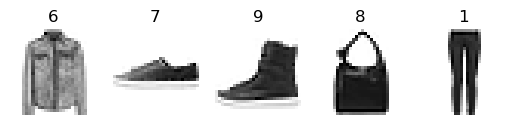

In [4]:
import matplotlib.pyplot as plt

for X, y in train_set.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i].numpy(), cmap="binary")
        plt.axis("off")
        plt.title(str(y[i].numpy()))

In [5]:
import numpy as np
from datetime import datetime
from pathlib import Path


standardization = tf.keras.layers.Normalization(input_shape=[28, 28])

sample_image_batches = train_set.take(100).map(lambda image, label: image)
sample_images = np.concatenate(list(sample_image_batches.as_numpy_iterator()),
                               axis=0).astype(np.float32)
standardization.adapt(sample_images)

model = tf.keras.Sequential([
    standardization,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam", metrics=["accuracy"])

logs = Path() / "my_logs" / "run_" / datetime.now().strftime("%Y%m%d_%H%M%S")

tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=logs, histogram_freq=1, profile_batch=10)

model.fit(train_set, epochs=5, validation_data=valid_set,
          callbacks=[tensorboard_cb])

Epoch 1/5


2025-10-13 19:10:55.837865: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2025-10-13 19:10:55.837882: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2025-10-13 19:10:55.837902: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


    122/Unknown - 0s 2ms/step - loss: 0.7629 - accuracy: 0.7257

2025-10-13 19:10:56.128960: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2025-10-13 19:10:56.128974: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2025-10-13 19:10:56.130936: I tensorflow/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2025-10-13 19:10:56.133340: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2025-10-13 19:10:56.134265: I tensorflow/tsl/profiler/rpc/client/save_profile.cc:144] Collecting XSpace to repository: my_logs/run_/20251013_191055/plugins/profile/2025_10_13_19_10_56/192.168.1.5.xplane.pb


1719/1719 [==============================] - 4s 2ms/step - loss: 0.4456 - accuracy: 0.8399 - val_loss: 0.3534 - val_accuracy: 0.8734
Epoch 2/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3316 - accuracy: 0.8786 - val_loss: 0.3456 - val_accuracy: 0.8792
Epoch 3/5
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2954 - accuracy: 0.8919 - val_loss: 0.3165 - val_accuracy: 0.8850
Epoch 4/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2703 - accuracy: 0.9001 - val_loss: 0.3250 - val_accuracy: 0.8850
Epoch 5/5
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2501 - accuracy: 0.9075 - val_loss: 0.3372 - val_accuracy: 0.8858


Para abrir TensorBoard 

Desde CMD:
     tensorboard --logdir my_logs --port 6006 --reload_interval 2

Y entrar a http://localhost:6006


O desde Jupyter:
    
    %load_ext tensorboard
    
    %tensorboard --logdir my_logs --port 6006 --reload_interval 2


In [6]:
%tensorboard --logdir my_logs --port 6006 --reload_interval 2

UsageError: Line magic function `%tensorboard` not found.


# Ejercicio 10

Download the Large Movie Review Dataset, which contains 50,000 movie reviews from the Internet Movie Database (IMDb). The data is organized in two directories, train and test, each containing a pos subdirectory with 12,500 positive reviews and a neg subdirectory with 12,500 negative reviews. Each review is stored in a separate text file. There are other files and folders (including preprocessed bag-of-words versions), but we will ignore them in this exercise. Split the test set into a validation set (15,000) and a test set (10,000). 

Use tf.data to create an efficient dataset for each set. Create a binary classification model, using a TextVectorization layer to preprocess each review.

Add an Embedding layer and compute the mean embedding for each review, multiplied by the square root of the number of words (see Chapter 16). 

This rescaled mean embedding can then be passed to the rest of your model. 

Train the model and see what accuracy you get. 

Try to optimize your pipelines to make training as fast as possible. Use TFDS to load the same dataset more easily: tfds.load("imdb_reviews").

In [23]:
from pathlib import Path
import numpy as np

root = "https://ai.stanford.edu/~amaas/data/sentiment/"
filename = "aclImdb_v1.tar.gz"
filepath = tf.keras.utils.get_file(filename, root + filename, extract=True,
                                   cache_dir="./")
if "_extracted" in filepath:
    path = Path(filepath) / "aclImdb"
else:
    path = Path(filepath).with_name("aclImdb")

In [24]:
def tree(path, level=0, indent=4, max_files=3):
    if level == 0:
        print(f"{path}/")
        level += 1
    sub_paths = sorted(path.iterdir())
    sub_dirs = [sub_path for sub_path in sub_paths if sub_path.is_dir()]
    filepaths = [sub_path for sub_path in sub_paths if not sub_path in sub_dirs]
    indent_str = " " * indent * level
    for sub_dir in sub_dirs:
        print(f"{indent_str}{sub_dir.name}/")
        tree(sub_dir,  level + 1, indent)
    for filepath in filepaths[:max_files]:
        print(f"{indent_str}{filepath.name}")
    if len(filepaths) > max_files:
        print(f"{indent_str}...")

print(tree(path))

datasets/aclImdb/
    test/
        neg/
            0_2.txt
            10000_4.txt
            10001_1.txt
            ...
        pos/
            0_10.txt
            10000_7.txt
            10001_9.txt
            ...
        labeledBow.feat
        urls_neg.txt
        urls_pos.txt
    train/
        neg/
            0_3.txt
            10000_4.txt
            10001_4.txt
            ...
        pos/
            0_9.txt
            10000_8.txt
            10001_10.txt
            ...
        unsup/
            0_0.txt
            10000_0.txt
            10001_0.txt
            ...
        labeledBow.feat
        unsupBow.feat
        urls_neg.txt
        ...
    README
    imdb.vocab
    imdbEr.txt
None


In [25]:
def review_paths(dirpath):
    return [str(path) for path in dirpath.glob("*.txt")]

train_pos = review_paths(path / "train" / "pos")
train_neg = review_paths(path / "train" / "neg")
test_valid_pos = review_paths(path / "test" / "pos")
test_valid_neg = review_paths(path / "test" / "neg")

len(train_pos), len(train_neg), len(test_valid_pos), len(test_valid_neg)

(12500, 12500, 12500, 12500)

In [26]:
np.random.shuffle(test_valid_pos)

test_pos = test_valid_pos[:5000]
test_neg = test_valid_neg[:5000]
valid_pos = test_valid_pos[5000:]
valid_neg = test_valid_neg[5000:]

In [27]:
test_pos[1]

'datasets/aclImdb/test/pos/7474_9.txt'

In [28]:
def imdb_dataset(filepaths_positive, filepaths_negative):
    reviews = []
    labels = []
    for filepaths, label in ((filepaths_negative, 0), (filepaths_positive, 1)):
        for filepath in filepaths:
            with open(filepath) as review_file:
                reviews.append(review_file.read())
            labels.append(label)
    return tf.data.Dataset.from_tensor_slices(
        (tf.constant(reviews), tf.constant(labels)))

In [29]:
for X, y in imdb_dataset(train_pos, train_neg).take(3):
    print(X)
    print(y)
    print()

tf.Tensor(b"Working with one of the best Shakespeare sources, this film manages to be creditable to it's source, whilst still appealing to a wider audience.<br /><br />Branagh steals the film from under Fishburne's nose, and there's a talented cast on good form.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int32)

tf.Tensor(b'Well...tremors I, the original started off in 1990 and i found the movie quite enjoyable to watch. however, they proceeded to make tremors II and III. Trust me, those movies started going downhill right after they finished the first one, i mean, ass blasters??? Now, only God himself is capable of answering the question "why in Gods name would they create another one of these dumpster dives of a movie?" Tremors IV cannot be considered a bad movie, in fact it cannot be even considered an epitome of a bad movie, for it lives up to more than that. As i attempted to sit though it, i noticed that my eyes started to bleed, and i hoped profusely that the little 

In [30]:

%timeit -r1 for X, y in imdb_dataset(train_pos, train_neg).repeat(10): pass

17.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


It takes about 17 seconds to load the dataset and go through it 10 times.

But let's pretend the dataset does not fit in memory, just to make things more interesting. Luckily, each review fits on just one line (they use <br /> to indicate line breaks), so we can read the reviews using a TextLineDataset. If they didn't we would have to preprocess the input files (e.g., converting them to TFRecords). For very large datasets, it would make sense to use a tool like Apache Beam for that.

In [31]:
def imdb_dataset(filepaths_positive, filepaths_negative, n_read_threads=5):
    dataset_neg = tf.data.TextLineDataset(filepaths_negative,
                                          num_parallel_reads=n_read_threads)
    dataset_neg = dataset_neg.map(lambda review: (review, 0))
    dataset_pos = tf.data.TextLineDataset(filepaths_positive,
                                          num_parallel_reads=n_read_threads)
    dataset_pos = dataset_pos.map(lambda review: (review, 1))
    return tf.data.Dataset.concatenate(dataset_pos, dataset_neg)

%timeit -r1 for X, y in imdb_dataset(train_pos, train_neg).repeat(10): pass

17 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Now it takes about 33 seconds to go through the dataset 10 times. That's much slower, essentially because the dataset is not cached in RAM, so it must be reloaded at each epoch. If you add .cache() just before .repeat(10), you will see that this implementation will be about as fast as the previous one.

In [72]:
def load_dataset_with_label(fp, n_parse_threads=5):
  label = tf.cast(tf.strings.regex_full_match(fp, '.*/pos/.*'), tf.int32)
  return tf.data.TextLineDataset(fp).map(lambda line: (line, label), num_parallel_calls=n_parse_threads)

In [102]:
import tensorflow as tf

def imdb_reader_dataset(filepaths,
                       n_readers=5,
                       n_parse_threads=5,
                       shuffle_buffer_size=10000,
                       seed=42,
                       batch_size=32):
  dataset = tf.data.Dataset.list_files(filepaths, seed=seed)
  dataset = dataset.interleave(
    lambda filepath: load_dataset_with_label(filepath),
    cycle_length=n_readers,
    num_parallel_calls=tf.data.AUTOTUNE
  )
  dataset = dataset.shuffle(shuffle_buffer_size, seed=seed)
  return dataset.batch(batch_size).prefetch(1)

In [69]:

dataset = imdb_reader_dataset(train_pos + train_neg)
%timeit -r1 for X in dataset.repeat(10): pass

23.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [71]:
training_dataset = imdb_reader_dataset(train_pos + train_neg)
%timeit -r1 for X in training_dataset.cache().repeat(10): pass

2.66 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [95]:
training_dataset = imdb_reader_dataset(train_pos + train_neg)
training_sample = training_dataset.take(500).map(lambda review, label: review)

text_vectorization_layer = tf.keras.layers.TextVectorization(
    max_tokens=1000,
    output_mode="tf_idf",
)
text_vectorization_layer.adapt(training_sample)

In [96]:
text_vectorization_layer.get_vocabulary()[:10]

['[UNK]', 'the', 'a', 'and', 'of', 'to', 'is', 'in', 'it', 'i']

In [97]:
tf.random.set_seed(42)

validation_dataset = imdb_reader_dataset(valid_pos + valid_neg)

model = tf.keras.Sequential([
    text_vectorization_layer,
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.fit(training_dataset, epochs=5, validation_data=validation_dataset)


Epoch 1/5
782/782 [==============================] - 8s 8ms/step - loss: 0.4415 - accuracy: 0.8202 - val_loss: 0.3648 - val_accuracy: 0.8462
Epoch 2/5
782/782 [==============================] - 8s 8ms/step - loss: 0.3592 - accuracy: 0.8558 - val_loss: 0.4355 - val_accuracy: 0.8243
Epoch 3/5
782/782 [==============================] - 8s 8ms/step - loss: 0.3111 - accuracy: 0.8727 - val_loss: 0.3541 - val_accuracy: 0.8507
Epoch 4/5
782/782 [==============================] - 8s 8ms/step - loss: 0.2546 - accuracy: 0.8980 - val_loss: 0.4480 - val_accuracy: 0.8245
Epoch 5/5
782/782 [==============================] - 7s 7ms/step - loss: 0.1894 - accuracy: 0.9264 - val_loss: 0.3844 - val_accuracy: 0.8490


In [111]:
tf.random.set_seed(42)

def compute_mean_embedding(inputs):
    not_pad = tf.math.count_nonzero(inputs, axis=-1)
    n_words = tf.math.count_nonzero(not_pad, axis=-1, keepdims=True)    
    sqrt_n_words = tf.math.sqrt(tf.cast(n_words, tf.float32))
    return tf.reduce_sum(inputs, axis=1) / sqrt_n_words

another_example = tf.constant([[[1., 2., 3.], [4., 5., 0.], [0., 0., 0.]],
                               [[6., 0., 0.], [0., 0., 0.], [0., 0., 0.]]])
compute_mean_embedding(another_example)


embedding_size = 20
max_tokens = 1000

text_vectorization_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
)

training_dataset = imdb_reader_dataset(train_pos + train_neg)
training_sample = training_dataset.take(1000)
adapt_sample = training_sample.map(lambda review, label: review)

validation_dataset = imdb_reader_dataset(valid_pos + valid_neg).take(1000)

text_vectorization_layer = tf.keras.layers.TextVectorization(
    max_tokens=1000,
    output_mode="int",
)
text_vectorization_layer.adapt(adapt_sample)

model = tf.keras.Sequential([
    text_vectorization_layer,
    tf.keras.layers.Embedding(input_dim=max_tokens,
                              output_dim=embedding_size,
                              mask_zero=True),  # <pad> tokens => zero vectors
    tf.keras.layers.Lambda(compute_mean_embedding),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit(training_sample, epochs=5, validation_data=validation_dataset)



Epoch 1/5
782/782 [==============================] - 9s 10ms/step - loss: 0.4847 - accuracy: 0.7595 - val_loss: 0.3482 - val_accuracy: 0.8545
Epoch 2/5
782/782 [==============================] - 8s 9ms/step - loss: 0.3441 - accuracy: 0.8515 - val_loss: 0.3820 - val_accuracy: 0.8253
Epoch 3/5
782/782 [==============================] - 9s 9ms/step - loss: 0.3242 - accuracy: 0.8620 - val_loss: 0.3181 - val_accuracy: 0.8611
Epoch 4/5
782/782 [==============================] - 8s 9ms/step - loss: 0.3150 - accuracy: 0.8641 - val_loss: 0.3342 - val_accuracy: 0.8527
Epoch 5/5
782/782 [==============================] - 8s 8ms/step - loss: 0.3090 - accuracy: 0.8680 - val_loss: 0.3286 - val_accuracy: 0.8555
